In [3]:
# import useful packages
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Reset the default graph for rerun notebook
tf.reset_default_graph()

# Reset the random seed for reproducibility
np.random.seed(42)
tf.set_random_seed(42)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


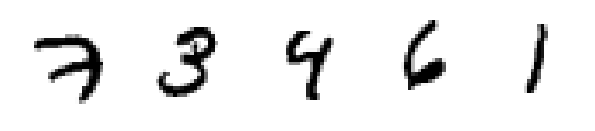

In [6]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [7]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [8]:
# Conv layer
conv1_params = {
   "filters": 256,
   "kernel_size": 9,
   "strides": 1,
   "padding": "valid",
   "activation": tf.nn.relu,
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)

In [9]:
# Primary Capsnes
caps1_n_maps = 32
caps1_n_dims = 8

conv2_params = {
   "filters": caps1_n_maps * caps1_n_dims,
   "kernel_size": 9,
   "strides": 2,
   "padding": "valid",
   "activation": tf.nn.relu
}

conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

In [13]:
caps1_n_caps = caps1_n_maps * 6 * 6

caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name="caps1_raw")

In [14]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [15]:
caps1_output = squash(caps1_raw, name="caps1_output")

In [16]:
# Digit Capsules

# Weights
caps2_n_caps = 10
caps2_n_dims = 16

init_sigma = 0.01

W_init = tf.random_normal(
   shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
   stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [17]:

caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                     name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                 name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                           name="caps1_output_tiled")